In [1]:
import chess.pgn
import pandas as pd


header_list = ['Event',
 'Site',
 'Date',
 'Round',
 'White',
 'Black',
 'Result',
 'BlackElo',
 'ECO',
 'Opening',
 'Termination',
 'TimeControl',
 'UTCDate',
 'UTCTime',
 'WhiteElo',
 'Tournament'
]



def open_and_scrape_headers(filepath):
    game_id = 0
    g = pd.DataFrame(columns=['game_id'] + header_list)

    with open(filepath) as f:

        while True:
            game = chess.pgn.read_game(f)
            game_id += 1

            # If there are no more games, exit the loop
            if game is None:
                break

            value_list = [game_id]
            for header in header_list:
                try:
                    value_list.append(game.headers[header])
                except:
                    value_list.append('')

            g.loc[len(g)] = value_list

            if (game_id % 20000 == 0):
                print('Now adding game_id: ' + str(game_id))

    return g



def open_white_and_black(filepath_white, filepath_black):
    game_id = 0
    g = pd.DataFrame(columns=['game_id'] + header_list)

    with open(filepath_white) as f:

        while True:
            game = chess.pgn.read_game(f)
            game_id += 1

            if game is None:
                break

            value_list = [game_id]
            for header in header_list:
                try:
                    value_list.append(game.headers[header])
                except:
                    value_list.append('')

            g.loc[len(g)] = value_list
    
    with open(filepath_black) as f:

        while True:
            game = chess.pgn.read_game(f)
            game_id += 1

            if game is None:
                break

            value_list = [game_id]
            for header in header_list:
                try:
                    value_list.append(game.headers[header])
                except:
                    value_list.append('')

            g.loc[len(g)] = value_list
        
    
    g = g.sort_values(by=['UTCDate', 'UTCTime'], ascending=True)

    return g




def get_metrics(data: pd.DataFrame, player_name: str, step: int, filter_opp_el = None):    
    metrics_data = []
    
    n = (len(data) // step) * step
    
    for i in range(0, n , step):
        mean_rating = 0
        wins, losses, draws = 0, 0, 0
        performance = 0
        period_label = ""
        
        count_j = 0
        j = 0
        while count_j < step:
            k = i + j
            
            if k >= len(data):
                break
            
            opponent_elo = "BlackElo" if player_name == data.iloc[k]["White"] else "WhiteElo"
            
            if filter_opp_el is not None:
                if not filter_opp_el(data.iloc[k][opponent_elo]):
                    j += 1
                    continue
            
            
            if player_name == data.iloc[k]["White"]:
                opponent_elo = "BlackElo"
                
                if data.iloc[k]["Result"] == "1-0":
                    wins += 1
                elif data.iloc[k]["Result"] == "0-1":
                    losses += 1
                elif data.iloc[k]["Result"] == "1/2-1/2":
                    draws += 1
                else:
                    raise Exception
            elif player_name == data.iloc[k]["Black"]:
                opponent_elo = "WhiteElo"
                
                if data.iloc[k]["Result"] == "0-1":
                    wins += 1
                elif data.iloc[k]["Result"] == "1-0":
                    losses += 1
                elif data.iloc[k]["Result"] == "1/2-1/2":
                    draws += 1
                else:
                    raise Exception
            else:
                raise Exception
                
            mean_rating += data.iloc[k][opponent_elo]
            performance += data.iloc[k][opponent_elo]
            
            count_j += 1
            j += 1
        
        if count_j == step:
            mean_rating /= step  
            performance = (performance + 400 * (wins - losses)) / step
            period_label = f'{data.iloc[i + step - 1]["UTCDate"]}\n{data.iloc[i + 0]["UTCDate"]}'
                
            row = {
                "mean_rating": mean_rating,
                "wins": wins,
                "losses": losses,
                "draws": draws,
                "performance": performance,
                "period": period_label,
            }

            metrics_data.append(row)
        
    
    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df


def load_data(player):
    df = open_white_and_black(
        f'/home/amedvedev/PycharmProjects/chessgamesstat/data/{player}/{player}-white.pgn',
        f'/home/amedvedev/PycharmProjects/chessgamesstat/data/{player}/{player}-black.pgn',
    ).astype({'BlackElo': 'int32', 'WhiteElo': 'int32'})
    return df


def add_player(all_data, player):
    all_data[player] = load_data(player)

In [2]:
PLAYERS = ["FabianoCaruana", "Duhless", "MagnusCarlsen", "Jospem", "vovachesss", "MatthewG-p4p", "HansOnTwitch", "shimastream", "PeshkaCh"]


In [3]:
all_data = {player: load_data(player) for player in PLAYERS}


In [39]:
# add_player(all_data, "PeshkaCh")

In [4]:
for player in PLAYERS:
    print(f"{player} played", len(all_data[player][all_data[player]['Tournament'].str.contains('titled')]), "titled games")

FabianoCaruana played 1318 titled games
Duhless played 1422 titled games
MagnusCarlsen played 678 titled games
Jospem played 3102 titled games
vovachesss played 1484 titled games
MatthewG-p4p played 1141 titled games
HansOnTwitch played 471 titled games
shimastream played 1376 titled games
PeshkaCh played 932 titled games


In [28]:
step = 20

criterion_opp_elo = 3000
groups = {
    player: 
              get_metrics(
                  all_data[player][~all_data[player]['Tournament'].str.contains('titled')], 
                  player, 
                  step, 
                  lambda opp_elo: opp_elo > criterion_opp_elo
              ) 
    for player in PLAYERS
}

In [32]:
groups[]

KeyError: 0

In [11]:
import numpy as np
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

PeshkaCh ignored


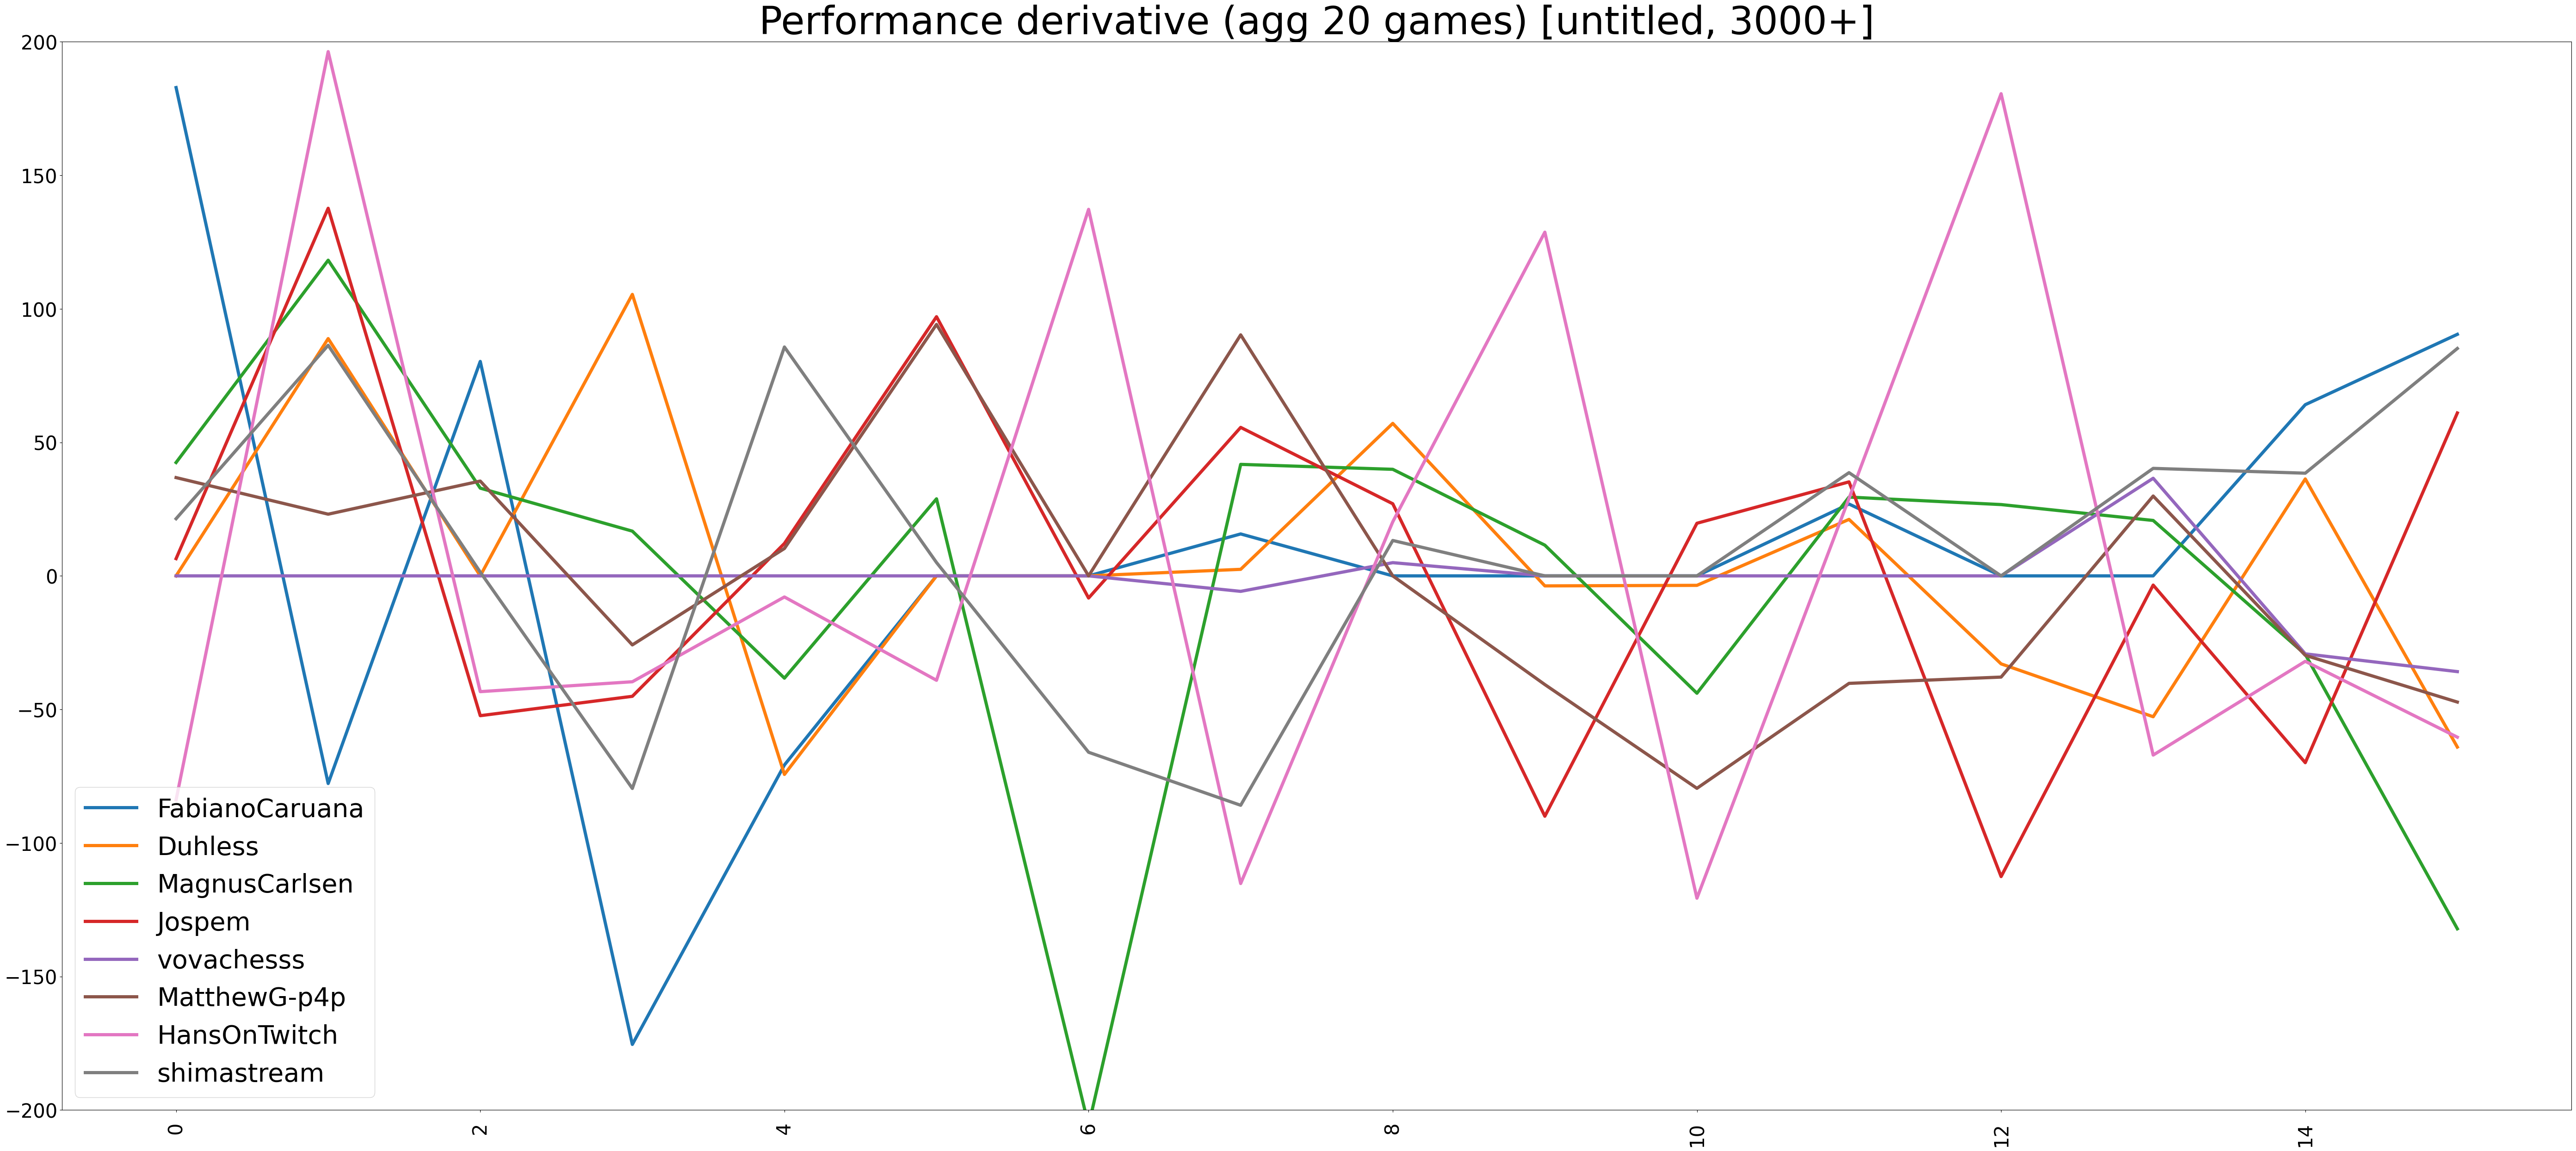

In [34]:
import matplotlib.pyplot as plt
plt.style.use('default')


plt.figure(figsize=(70, 30))
plt.title(f"Performance derivative (agg {step} games) [untitled, {criterion_opp_elo}+]", fontsize=60)

for player, selection in groups.items():
    if not "performance" in selection:
        print(f"{player} ignored")
        continue
    #plt.plot(selection["period"][-30:], selection["performance"].diff()[-30:], label=player)
    #plt.plot(moving_average(list(selection["performance"].diff())[-30:], 3), label=player)
    arr = list(selection["performance"].diff())[-16:]
    plt.plot(arr, label=player, linewidth=5.0)
    
    # plt.scatter(np.arange(1, len(arr) + 1, 1), np.abs(arr), label=player, s=360)
    
plt.yticks(fontsize=30)
plt.xticks(fontsize=30,  rotation=90)
plt.tick_params(axis='x', which='major', pad=15)
plt.ylim(-200, 200)
plt.legend(prop={'size': 40})
plt.savefig(f"Performance derivative({step}) [untitled, {criterion_opp_elo}+].png")

In [35]:
def plot_performance_diff_player(player, xs, arr, criterion_opp_elo):
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    
    plt.clf()
    plt.figure(figsize=(70, 30))
    plt.title(f"Performance derivative [untitled, {criterion_opp_elo}+]", fontsize=60)
    
    plt.bar(xs, arr, label=player)
        
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30,  rotation=90)
    plt.tick_params(axis='x', which='major', pad=15)
    plt.ylim(-200, 200)
    plt.legend(prop={'size': 40})
    plt.savefig(f"reports/performance_diff_bars/Performance derivative({step}) by {player} [untitled, {criterion_opp_elo}+].png")
    plt.close()

for player, selection in groups.items():
    if not "performance" in selection:
        print(f"{player} ignored")
        continue
    plot_performance_diff_player(player, selection["period"], list(selection["performance"].diff()), criterion_opp_elo)

PeshkaCh ignored


<Figure size 640x480 with 0 Axes>

PeshkaCh ignored


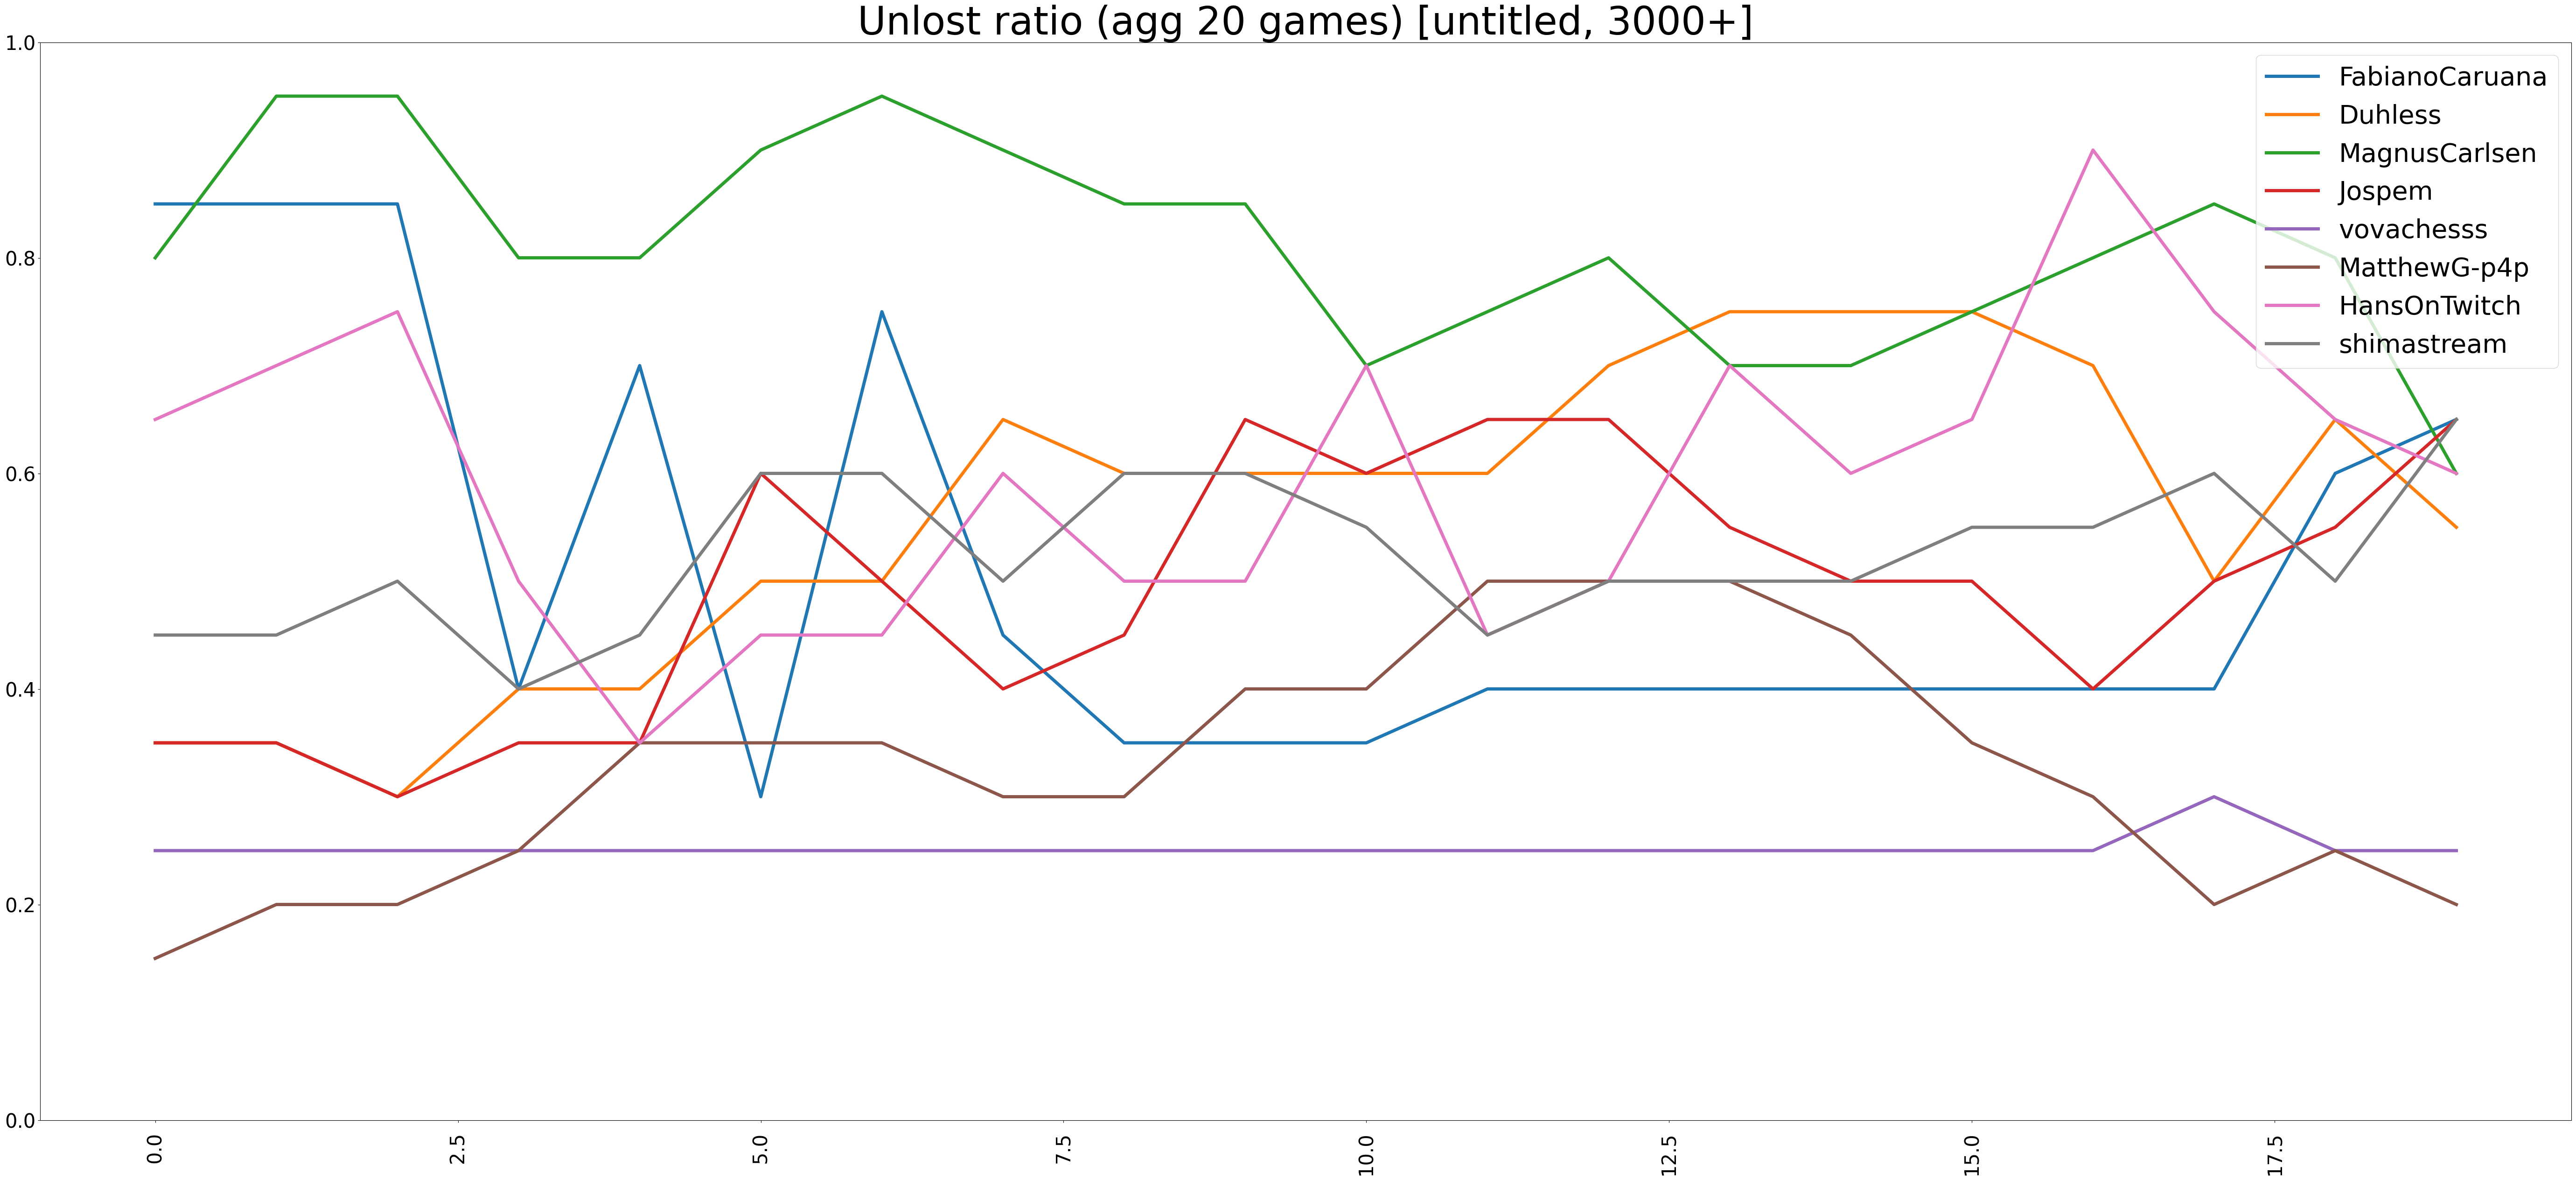

In [36]:
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
plt.style.use('default')


plt.figure(figsize=(70, 30))
plt.title(f"Unlost ratio (agg {step} games) [untitled, {criterion_opp_elo}+]", fontsize=60)

for player, selection in groups.items():
    if not "wins" in selection:
        print(f"{player} ignored")
        continue
    #plt.plot(selection["period"][-30:], selection["performance"].diff()[-30:], label=player)
    #plt.plot(moving_average(list(selection["performance"].diff())[-30:], 3), label=player)
    arr = list(((selection["wins"] + selection["draws"]) / (selection["wins"] + selection["losses"] + selection["draws"])))[-20:]
    plt.plot(arr, label=player, linewidth=5.0)
    
    # plt.scatter(np.arange(1, len(arr) + 1, 1), np.abs(arr), label=player, s=360)
    
plt.yticks(fontsize=30)
plt.xticks(fontsize=30,  rotation=90)
plt.tick_params(axis='x', which='major', pad=15)
plt.legend(prop={'size': 40})
plt.ylim(0, 1)
plt.savefig(f"Unlost ratio ({step}) [untitled, {criterion_opp_elo}+].png")

In [37]:
def plot_unlost_score_player(player, xs, arr, criterion_opp_elo):
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    
    plt.clf()
    plt.figure(figsize=(70, 30))
    plt.title(f"Unlost ratio (agg {step} games) [untitled, {criterion_opp_elo}+]", fontsize=60)

    plt.plot(xs, arr, label=player)
        
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30,  rotation=90)
    plt.tick_params(axis='x', which='major', pad=15)
    plt.ylim(0, 1)
    plt.legend(prop={'size': 40})
    plt.savefig(f"reports/unlost_score/Unlost ratio by {player} (agg {step} games) [untitled, {criterion_opp_elo}+].png")
    plt.close()

for player, selection in groups.items():
    if not "wins" in selection:
        print(f"{player} ignored")
        continue
    plot_unlost_score_player(player, selection["period"], 
                             list(((selection["wins"] + selection["draws"]) / (selection["wins"] + selection["losses"] + selection["draws"]))), 
                             criterion_opp_elo)

PeshkaCh ignored


<Figure size 640x480 with 0 Axes>